In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from collections import defaultdict
from typing import List, Dict
from typing import Tuple, Any
from torch.nn import MSELoss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
from gcn import GCNLayer
from transformer import TransformerModel
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "T4_CPUALL"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False
model_type = ModelType.GCNGrouping
method_prefix = "GroupingBased"

In [4]:

eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=200_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=1000_000)

[2023-12-20 16:16:13,065] {data.py:447} INFO - Loading graphs train
[2023-12-20 16:16:13,066] {data.py:418} INFO - Loading merged.csv
[2023-12-20 16:16:13,066] {data.py:418} INFO - Loading merged.csv
[2023-12-20 16:16:13,562] {data.py:421} INFO - Loaded merged.csv, 200000 rows
[2023-12-20 16:16:13,916] {data.py:427} INFO - Loaded mnasnet1_3.180_7.csv, 769 rows
[2023-12-20 16:16:14,609] {data.py:427} INFO - Loaded convnext_small.96_7.csv, 1595 rows
[2023-12-20 16:16:15,007] {data.py:427} INFO - Loaded googlenet.120_7.csv, 905 rows
[2023-12-20 16:16:15,330] {data.py:427} INFO - Loaded mobilenet_v3_small.249_7.csv, 732 rows
[2023-12-20 16:16:15,461] {data.py:427} INFO - Loaded squeezenet1_0.173_7.csv, 280 rows
[2023-12-20 16:16:15,784] {data.py:427} INFO - Loaded rand_4000.251_7.csv, 719 rows
[2023-12-20 16:16:16,875] {data.py:427} INFO - Loaded densenet161.132_7.csv, 2507 rows
[2023-12-20 16:16:18,022] {data.py:427} INFO - Loaded densenet169.127_7.csv, 2633 rows
[2023-12-20 16:16:18,179]

In [17]:
train_configs = {
    ModelType.MLPTestGrouping.name: Config.from_dict({
        "model": "MLPTestGrouping",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_grouping_count":20,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-4,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GCNGrouping.name: Config.from_dict({
        "model": "GCNGrouping",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_grouping_count": 25,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 25,
        "learning_rate": 1e-4,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
}

conf: Config = train_configs[model_type.name]

In [18]:
def full_graph_feature(graph: Graph, subgraph_count: int = 10, dataset_params: Dict = {}) -> Tuple[
    Dict[str, np.ndarray], Dict]:
    subgraphs, node_id_to_group_idx = graph.subgraphs(subgraph_count=subgraph_count)

    feature_matrix = list()
    for subgraph in subgraphs:
        subgraph_features = list()
        for node in subgraph:
            node_feature = np.array(node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex")))
            subgraph_features.append(node_feature)
        if len(subgraph_features) == 0:
            feature_matrix.append(np.zeros(1))
            continue
        subgraph_features = pad_np_vectors(subgraph_features)
        feature = np.sum(subgraph_features, axis=0)
        feature = np.append(feature, len(subgraph))
        feature_matrix.append(feature)
    adj_matrix = [
            [0.] * len(subgraphs) for _ in range(len(subgraphs))
    ]
    for curr_idx in range(len(subgraphs)):
        if curr_idx + 1 < len(subgraphs):
            adj_matrix[curr_idx][curr_idx+1] = 1.

    adj_matrix = np.array(adj_matrix)

    # adjacency_matrix = list()
    # for i, subgraph in enumerate(subgraphs):
    #     vector = np.zeros(len(subgraphs) + 1)
    #     for node in subgraph:
    #         neighbor_group_indices = list()
    #         for neighbor in node.neighbors:
    #             neighbor_group_idx = node_id_to_group_idx[neighbor.node_id]
    #             if neighbor_group_idx != i:
    #                 neighbor_group_indices.append(neighbor_group_idx)
    #         for idx in neighbor_group_indices:
    #             vector[idx] = 1
    #     adjacency_matrix.append(vector)

    feature_matrix = pad_np_vectors(feature_matrix)
    feature_matrix = np.array(feature_matrix)
    adj_matrix = np.array(adj_matrix)

    x = {
        "x_graph_id": graph.ID,
        "x_feature_matrix": feature_matrix,
        "x_adjacency_matrix": adj_matrix,
    }
    y = {
        "y_graph_id": graph.ID,
        "y_graph_duration": (graph.graph_duration,)
    }
    return x, y

def init_dataset(graphs: List[Graph]) -> MDataset:
    X = list()
    Y = list()

    feature_matrix_maxsize = 0
    adjacency_matrix_maxsize = 0

    for graph in graphs:
        x, y = full_graph_feature(graph,
                                subgraph_count=conf.dataset_subgraph_grouping_count,
                                dataset_params=conf.dataset_params)
        feature_matrix_size = len(x["x_feature_matrix"][0])
        adjacency_matrix_size = len(x["x_adjacency_matrix"][0])
        # print(f"feature_matrix_size: {x['x_feature_matrix'].shape}, adjacency_matrix_size: {x['x_adjacency_matrix'].shape}")
        feature_matrix_maxsize = max(feature_matrix_maxsize, feature_matrix_size)
        adjacency_matrix_maxsize = max(adjacency_matrix_maxsize, adjacency_matrix_size)

        X.append(x)
        Y.append(y)
    for x in X:
        x["x_feature_matrix"] = pad_np_vectors(x["x_feature_matrix"], maxsize=feature_matrix_maxsize)
        x["x_adjacency_matrix"] = pad_np_vectors(x["x_adjacency_matrix"], maxsize=adjacency_matrix_maxsize)

    dataset = MDataset(X, Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [19]:
def get_scalers(ds: MDataset):
    scaler_cls = conf.dataset_normalizer_cls
    graph_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        x_feature_matrix = feature["x_feature_matrix"]
        assert isinstance(x_feature_matrix, list)
        graph_feature_array.extend(x_feature_matrix)
        y_array.append(label["y_graph_duration"])

    graph_feature_array = np.array(graph_feature_array)
    y_array = np.array(y_array)

    graph_feature_scaler = scaler_cls()
    graph_feature_scaler.fit(graph_feature_array)

    y_scaler = scaler_cls()
    y_scaler.fit(y_array)
    return graph_feature_scaler, y_scaler

scalers = get_scalers(train_ds)
graph_feature_scaler, y_scaler = scalers


In [20]:
def preprocess_dataset(ds: MDataset) -> MDataset:
    y_array = list()

    graph_feature_scaler, y_scaler = scalers
    graph_feature_arrays = list()
    for data in ds:
        feature, label = data
        # x. transform for each x feature matrix. do not merge them.
        x_feature_matrix = feature["x_feature_matrix"]
        x_feature_matrix = np.array(x_feature_matrix, dtype=np.float32)

        graph_feature_array = graph_feature_scaler.transform(x_feature_matrix)
        graph_feature_arrays.append(graph_feature_array)
        # y. transform altogether
        y_array.append(label["y_graph_duration"])

    y_array = np.array(y_array, dtype=np.float32)
    y_array = y_scaler.transform(y_array)

    processed_features = list()
    processed_labels = list()
    for i, data in enumerate(ds):
        feature, label = data
        x_adjacency_matrix = np.array(feature["x_adjacency_matrix"], dtype=np.float32)
        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_feature_matrix": torch.Tensor(graph_feature_arrays[i]),
            "x_adjacency_matrix": torch.Tensor(x_adjacency_matrix)
        })
        # print(f"x_feature_matrix: {graph_feature_arrays[i].shape}, x_adjacency_matrix: {x_adjacency_matrix.shape}")
        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_graph_duration": torch.Tensor(y_array[i]),
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)


In [21]:

# save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, method_prefix, 'train',
#                          conf.dataset_normalization)
# save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, method_prefix, 'eval',
#                          conf.dataset_normalization)
# save_scalers_pkl(scalers, conf.dataset_environment, method_prefix, 'train',
#                          conf.dataset_normalization)

In [22]:
# preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'train', 
#                                          conf.dataset_normalization)
# preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'eval',
#                                         conf.dataset_normalization)
# scalers = load_scalers_pkl(conf.dataset_environment, method_prefix, 'train',
#                            conf.dataset_normalization)
# graph_feature_scaler, y_scaler = scalers

In [23]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    batches_len = len(input_batches)

    def compute_graph_duration(_logits):
        _, y_scaler = scalers
        transformed: np.ndarray = y_scaler.inverse_transform(_logits)
        duration_dim = (0, 1)
        durations = transformed[:, duration_dim[0]:duration_dim[1]].sum(axis=1)
        return durations

    graph_id_to_duration_pred = defaultdict(int)
    for idx in range(batches_len):
        inputs = input_batches[idx]
        logits = output_batches[idx]
        logits = nested_detach(logits)
        logits = logits.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_durations = compute_graph_duration(logits)
        for i, graph_id in enumerate(graph_ids):
            graph_duration = graph_durations[i].item()
            graph_id_to_duration_pred[graph_id] = graph_duration
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [24]:

def to_device(conf: Config, features, labels):
    features["x_feature_matrix"] = features["x_feature_matrix"].to(conf.device)
    features["x_adjacency_matrix"] = features["x_adjacency_matrix"].to(conf.device)
    labels["y_graph_duration"] = labels["y_graph_duration"].to(conf.device)
    return features, labels

In [25]:

class MLPTest_GroupingModel(MModule):

    def __init__(self, input_shape, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=input_shape[0] * input_shape[1], out_features=128)
        self.output = torch.nn.Linear(128, output_dimension)
        self.loss_fn = MSELoss()

    def forward(self, X):
        X = X["x_feature_matrix"]
        X = self.flatten(X)
        X = self.linear1(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        graph_duration = Y["y_graph_duration"]
        loss = self.loss_fn(outputs, graph_duration)
        return loss


def init_MLPTestGrouping_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    shape = len(sample_x_dict["x_feature_matrix"]), len(sample_x_dict["x_feature_matrix"][0])
    return MLPTest_GroupingModel(input_shape=shape,
                                    output_dimension=len(sample_y_dict["y_graph_duration"]))



In [26]:


class GCNGroupingModel(MModule):
    def __init__(self, dim_feats, dim_h, y_graph_duration_len, n_layers, dropout):
        super(GCNGroupingModel, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GCNLayer(dim_feats, dim_h, F.relu, 0))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GCNLayer(dim_h, dim_h, F.relu, dropout))
        # output layer
        self.layers.append(GCNLayer(dim_h, y_graph_duration_len, None, dropout))
        self.loss_fn = MSELoss()

    def forward(self, X):
        adj, features = X["x_adjacency_matrix"], X["x_feature_matrix"]
        h = features
        for layer in self.layers:
            h = layer(adj, h)
        graph_duration = torch.sum(h, dim=[1])
        return graph_duration

    def compute_loss(self, outputs, Y) -> torch.Tensor:
        y_graph_duration = Y["y_graph_duration"]
        loss = self.loss_fn(outputs, y_graph_duration)
        return loss


def init_GCNGrouping_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "dim_h": None,
            "n_layers": 8,
            "dropout": 0.01
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_feature_matrix"][0])
    y_graph_duration_len = len(sample_y_dict["y_graph_duration"])
    model_params = conf.model_params

    final_model_params = default_model_params()
    default_dim_h = x_node_feature_size if final_model_params.get("dim_h") is None else final_model_params.get(
        "dim_h")
    final_model_params["dim_h"] = model_params.get("dim_h", default_dim_h)
    final_model_params["n_layers"] = model_params.get("n_layers", final_model_params["n_layers"])
    final_model_params["dropout"] = model_params.get("dropout", final_model_params["dropout"])
    return GCNGroupingModel(
        dim_feats=x_node_feature_size,
        y_graph_duration_len=y_graph_duration_len,
        **final_model_params
    )


In [27]:
print(len(preprocessed_train_ds), len(preprocessed_eval_ds))

819 162


[2023-12-20 16:35:08,926] {executor.py:148} INFO - ModelType.GCNGrouping start single training.
[2023-12-20 16:35:08,927] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:08,937] {executor.py:111} INFO - ModelType.GCNGrouping trained for 0.010652523 seconds.
[2023-12-20 16:35:08,937] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 0.
[2023-12-20 16:35:08,950] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 36.173439025878906, eval metrics: {'eval_loss': 20.060420989990234, 'MRE': 16.65131034152191, 'MAE': 7.229375803462569, 'RMSE': 4432.612208497499}
[2023-12-20 16:35:08,950] {executor.py:187} INFO - Saving model at step 0 with loss 36.173439025878906,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


 50%|█████     | 13/26 [00:00<00:00, 122.46it/s]

[2023-12-20 16:35:09,121] {executor.py:111} INFO - ModelType.GCNGrouping trained for 0.195265479 seconds.
[2023-12-20 16:35:09,122] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 25.
[2023-12-20 16:35:09,135] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.94016033411026, eval metrics: {'eval_loss': 0.5807497501373291, 'MRE': 1.745472674375652, 'MAE': 0.8320635957720341, 'RMSE': 776.0048327664032}
[2023-12-20 16:35:09,136] {executor.py:187} INFO - Saving model at step 25 with loss 0.94016033411026,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 122.55it/s]

[2023-12-20 16:35:09,140] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 1



  0%|          | 0/26 [00:00<?, ?it/s]

 58%|█████▊    | 15/26 [00:00<00:00, 148.87it/s]

[2023-12-20 16:35:09,308] {executor.py:111} INFO - ModelType.GCNGrouping trained for 0.381620801 seconds.
[2023-12-20 16:35:09,308] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 50.
[2023-12-20 16:35:09,320] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.1060764491558075, eval metrics: {'eval_loss': 0.5820599465320507, 'MRE': 1.0184929198923107, 'MAE': 0.7430093075238663, 'RMSE': 787.4527402748666}
[2023-12-20 16:35:09,321] {executor.py:187} INFO - Saving model at step 50 with loss 0.1060764491558075,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.44it/s]

[2023-12-20 16:35:09,331] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 2



 62%|██████▏   | 16/26 [00:00<00:00, 155.41it/s]

[2023-12-20 16:35:09,489] {executor.py:111} INFO - ModelType.GCNGrouping trained for 0.562529912 seconds.
[2023-12-20 16:35:09,489] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 75.
[2023-12-20 16:35:09,502] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.9032046794891357, eval metrics: {'eval_loss': 0.5060804896056652, 'MRE': 1.2475672454298399, 'MAE': 0.7058277596696217, 'RMSE': 730.8418526048926}
[2023-12-20 16:35:09,502] {executor.py:187} INFO - Saving model at step 75 with loss 0.9032046794891357,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.59it/s]

[2023-12-20 16:35:09,520] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 3



 62%|██████▏   | 16/26 [00:00<00:00, 155.75it/s]

[2023-12-20 16:35:09,670] {executor.py:111} INFO - ModelType.GCNGrouping trained for 0.744390436 seconds.
[2023-12-20 16:35:09,671] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 100.
[2023-12-20 16:35:09,684] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 2.0135059356689453, eval metrics: {'eval_loss': 0.48510890267789364, 'MRE': 1.1864065457675566, 'MAE': 0.6820369876900667, 'RMSE': 715.7229654497357}
[2023-12-20 16:35:09,684] {executor.py:187} INFO - Saving model at step 100 with loss 2.0135059356689453,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.84it/s]

[2023-12-20 16:35:09,709] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 4



 62%|██████▏   | 16/26 [00:00<00:00, 151.66it/s]

[2023-12-20 16:35:09,856] {executor.py:111} INFO - ModelType.GCNGrouping trained for 0.929932939 seconds.
[2023-12-20 16:35:09,856] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 125.
[2023-12-20 16:35:09,869] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.6004164218902588, eval metrics: {'eval_loss': 0.4623453089346488, 'MRE': 1.2213679714571073, 'MAE': 0.6769021848406527, 'RMSE': 698.1855246407536}
[2023-12-20 16:35:09,870] {executor.py:187} INFO - Saving model at step 125 with loss 0.6004164218902588,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.08it/s]

[2023-12-20 16:35:09,900] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 5



 62%|██████▏   | 16/26 [00:00<00:00, 150.29it/s]

[2023-12-20 16:35:10,043] {executor.py:111} INFO - ModelType.GCNGrouping trained for 1.116880916 seconds.
[2023-12-20 16:35:10,043] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 150.
[2023-12-20 16:35:10,057] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.5160123705863953, eval metrics: {'eval_loss': 0.45916339630881947, 'MRE': 1.0969001591154908, 'MAE': 0.6764280726176378, 'RMSE': 697.0819983992495}
[2023-12-20 16:35:10,058] {executor.py:187} INFO - Saving model at step 150 with loss 0.5160123705863953,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 134.31it/s]

[2023-12-20 16:35:10,096] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 6



 62%|██████▏   | 16/26 [00:00<00:00, 151.51it/s]

[2023-12-20 16:35:10,230] {executor.py:111} INFO - ModelType.GCNGrouping trained for 1.303965536 seconds.
[2023-12-20 16:35:10,230] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 175.
[2023-12-20 16:35:10,244] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.13581784069538116, eval metrics: {'eval_loss': 0.42342134565114975, 'MRE': 1.129273223143233, 'MAE': 0.6551328361096186, 'RMSE': 669.057645956972}
[2023-12-20 16:35:10,244] {executor.py:187} INFO - Saving model at step 175 with loss 0.13581784069538116,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.62it/s]

[2023-12-20 16:35:10,287] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 7



 65%|██████▌   | 17/26 [00:00<00:00, 166.04it/s]

[2023-12-20 16:35:10,404] {executor.py:111} INFO - ModelType.GCNGrouping trained for 1.477570282 seconds.
[2023-12-20 16:35:10,404] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 200.
[2023-12-20 16:35:10,416] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.14287839829921722, eval metrics: {'eval_loss': 0.3982883111263315, 'MRE': 1.0413116226120758, 'MAE': 0.6310318942289902, 'RMSE': 650.2874664751748}
[2023-12-20 16:35:10,417] {executor.py:187} INFO - Saving model at step 200 with loss 0.14287839829921722,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 147.49it/s]

[2023-12-20 16:35:10,465] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 8



 65%|██████▌   | 17/26 [00:00<00:00, 161.37it/s]

[2023-12-20 16:35:10,579] {executor.py:111} INFO - ModelType.GCNGrouping trained for 1.653015059 seconds.
[2023-12-20 16:35:10,579] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 225.
[2023-12-20 16:35:10,592] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.29101940989494324, eval metrics: {'eval_loss': 0.35802703506002825, 'MRE': 1.071266432858086, 'MAE': 0.602550600885548, 'RMSE': 616.6984223279118}
[2023-12-20 16:35:10,593] {executor.py:187} INFO - Saving model at step 225 with loss 0.29101940989494324,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 145.66it/s]

[2023-12-20 16:35:10,645] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 9



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:10,752] {executor.py:111} INFO - ModelType.GCNGrouping trained for 1.826239489 seconds.
[2023-12-20 16:35:10,753] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 250.
[2023-12-20 16:35:10,765] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.9871941208839417, eval metrics: {'eval_loss': 0.33914887020364404, 'MRE': 0.8303155457333463, 'MAE': 0.5664637835277299, 'RMSE': 601.6790543725673}
[2023-12-20 16:35:10,766] {executor.py:187} INFO - Saving model at step 250 with loss 0.9871941208839417,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 145.16it/s]

[2023-12-20 16:35:10,826] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 10



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:10,930] {executor.py:111} INFO - ModelType.GCNGrouping trained for 2.004349593 seconds.
[2023-12-20 16:35:10,931] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 275.
[2023-12-20 16:35:10,944] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 4.567872047424316, eval metrics: {'eval_loss': 0.3148142055918773, 'MRE': 0.801910919190791, 'MAE': 0.5663314195183001, 'RMSE': 580.0624415292648}
[2023-12-20 16:35:10,944] {executor.py:187} INFO - Saving model at step 275 with loss 4.567872047424316,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.01it/s]

[2023-12-20 16:35:11,013] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 11



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:11,111] {executor.py:111} INFO - ModelType.GCNGrouping trained for 2.184927618 seconds.
[2023-12-20 16:35:11,111] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 300.
[2023-12-20 16:35:11,124] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.42033159732818604, eval metrics: {'eval_loss': 0.28986452364673215, 'MRE': 0.6362065251700563, 'MAE': 0.5393182140250399, 'RMSE': 556.0711023976208}
[2023-12-20 16:35:11,125] {executor.py:187} INFO - Saving model at step 300 with loss 0.42033159732818604,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.71it/s]

[2023-12-20 16:35:11,201] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 12



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:11,292] {executor.py:111} INFO - ModelType.GCNGrouping trained for 2.365954563 seconds.
[2023-12-20 16:35:11,293] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 325.
[2023-12-20 16:35:11,306] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 1.1673107147216797, eval metrics: {'eval_loss': 0.24917237041518092, 'MRE': 0.6407076464853407, 'MAE': 0.5154108047795071, 'RMSE': 515.9534274681396}
[2023-12-20 16:35:11,306] {executor.py:187} INFO - Saving model at step 325 with loss 1.1673107147216797,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.18it/s]

[2023-12-20 16:35:11,387] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 13



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:11,471] {executor.py:111} INFO - ModelType.GCNGrouping trained for 2.545411796 seconds.
[2023-12-20 16:35:11,472] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 350.
[2023-12-20 16:35:11,485] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 2.085569143295288, eval metrics: {'eval_loss': 0.2172810313447068, 'MRE': 0.5830186097410676, 'MAE': 0.46521671712225654, 'RMSE': 482.2279238654588}
[2023-12-20 16:35:11,485] {executor.py:187} INFO - Saving model at step 350 with loss 2.085569143295288,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 142.13it/s]

[2023-12-20 16:35:11,572] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 14



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:11,651] {executor.py:111} INFO - ModelType.GCNGrouping trained for 2.725072358 seconds.
[2023-12-20 16:35:11,652] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 375.
[2023-12-20 16:35:11,664] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.09304000437259674, eval metrics: {'eval_loss': 0.20159325601222614, 'MRE': 0.5665324038521036, 'MAE': 0.4458828113318052, 'RMSE': 464.3975268163304}
[2023-12-20 16:35:11,665] {executor.py:187} INFO - Saving model at step 375 with loss 0.09304000437259674,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.28it/s]

[2023-12-20 16:35:11,762] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 15



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:11,834] {executor.py:111} INFO - ModelType.GCNGrouping trained for 2.907694499 seconds.
[2023-12-20 16:35:11,834] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 400.
[2023-12-20 16:35:11,847] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.21046403050422668, eval metrics: {'eval_loss': 0.20837322855368257, 'MRE': 0.6640205201477116, 'MAE': 0.4938262031951544, 'RMSE': 470.9569951122409}
[2023-12-20 16:35:11,847] {executor.py:187} INFO - Saving model at step 400 with loss 0.21046403050422668,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 142.07it/s]

[2023-12-20 16:35:11,947] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 16



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:12,010] {executor.py:111} INFO - ModelType.GCNGrouping trained for 3.083868051 seconds.
[2023-12-20 16:35:12,010] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 425.
[2023-12-20 16:35:12,022] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.45259183645248413, eval metrics: {'eval_loss': 0.20639802298198143, 'MRE': 0.7256994144594952, 'MAE': 0.525346504280045, 'RMSE': 468.4778187092989}
[2023-12-20 16:35:12,023] {executor.py:187} INFO - Saving model at step 425 with loss 0.45259183645248413,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 147.48it/s]

[2023-12-20 16:35:12,125] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 17



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:12,183] {executor.py:111} INFO - ModelType.GCNGrouping trained for 3.256988054 seconds.
[2023-12-20 16:35:12,183] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 450.
[2023-12-20 16:35:12,196] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 1.2863454818725586, eval metrics: {'eval_loss': 0.2009780239313841, 'MRE': 0.8595217821267681, 'MAE': 0.5255395342276817, 'RMSE': 454.5757853422867}
[2023-12-20 16:35:12,196] {executor.py:187} INFO - Saving model at step 450 with loss 1.2863454818725586,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 142.81it/s]

[2023-12-20 16:35:12,309] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 18



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:12,362] {executor.py:111} INFO - ModelType.GCNGrouping trained for 3.435604784 seconds.
[2023-12-20 16:35:12,362] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 475.
[2023-12-20 16:35:12,375] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.25326240062713623, eval metrics: {'eval_loss': 0.20671004491547743, 'MRE': 0.8534509947912566, 'MAE': 0.5477689331540155, 'RMSE': 462.94027040745215}
[2023-12-20 16:35:12,375] {executor.py:187} INFO - Saving model at step 475 with loss 0.25326240062713623,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 140.76it/s]

[2023-12-20 16:35:12,496] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 19



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:12,543] {executor.py:111} INFO - ModelType.GCNGrouping trained for 3.617194764 seconds.
[2023-12-20 16:35:12,544] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 500.
[2023-12-20 16:35:12,556] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.2002457082271576, eval metrics: {'eval_loss': 0.16391533667532107, 'MRE': 0.6630915930224514, 'MAE': 0.4532946429115276, 'RMSE': 418.11139904358527}
[2023-12-20 16:35:12,557] {executor.py:187} INFO - Saving model at step 500 with loss 0.2002457082271576,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.95it/s]

[2023-12-20 16:35:12,686] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 20



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:12,727] {executor.py:111} INFO - ModelType.GCNGrouping trained for 3.801130741 seconds.
[2023-12-20 16:35:12,728] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 525.
[2023-12-20 16:35:12,740] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.9756146669387817, eval metrics: {'eval_loss': 0.14963369412968555, 'MRE': 0.6358276983259147, 'MAE': 0.4248298703947933, 'RMSE': 396.64544445170543}
[2023-12-20 16:35:12,741] {executor.py:187} INFO - Saving model at step 525 with loss 0.9756146669387817,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.31it/s]

[2023-12-20 16:35:12,875] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 21



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:12,909] {executor.py:111} INFO - ModelType.GCNGrouping trained for 3.982965965 seconds.
[2023-12-20 16:35:12,909] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 550.
[2023-12-20 16:35:12,922] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.3457697033882141, eval metrics: {'eval_loss': 0.1488358350470662, 'MRE': 0.6383658016856366, 'MAE': 0.43089915622766284, 'RMSE': 396.26027024450036}
[2023-12-20 16:35:12,922] {executor.py:187} INFO - Saving model at step 550 with loss 0.3457697033882141,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.88it/s]

[2023-12-20 16:35:13,068] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 22



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:13,097] {executor.py:111} INFO - ModelType.GCNGrouping trained for 4.170853842 seconds.
[2023-12-20 16:35:13,097] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 575.
[2023-12-20 16:35:13,110] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.08992324769496918, eval metrics: {'eval_loss': 0.14263005182147026, 'MRE': 0.6545125443619763, 'MAE': 0.4298664715024316, 'RMSE': 387.2004050919557}
[2023-12-20 16:35:13,111] {executor.py:187} INFO - Saving model at step 575 with loss 0.08992324769496918,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 136.96it/s]

[2023-12-20 16:35:13,260] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 23



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:13,281] {executor.py:111} INFO - ModelType.GCNGrouping trained for 4.35490301 seconds.
[2023-12-20 16:35:13,281] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 600.
[2023-12-20 16:35:13,294] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07775597274303436, eval metrics: {'eval_loss': 0.13820520540078482, 'MRE': 0.7097873808565021, 'MAE': 0.42978323335436586, 'RMSE': 376.1666762950768}
[2023-12-20 16:35:13,295] {executor.py:187} INFO - Saving model at step 600 with loss 0.07775597274303436,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 143.68it/s]

[2023-12-20 16:35:13,443] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 24



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:13,458] {executor.py:111} INFO - ModelType.GCNGrouping trained for 4.532299558 seconds.
[2023-12-20 16:35:13,459] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 625.
[2023-12-20 16:35:13,472] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07537317276000977, eval metrics: {'eval_loss': 0.1379652681450049, 'MRE': 0.7251445105090546, 'MAE': 0.4407278153433798, 'RMSE': 374.9669687924944}
[2023-12-20 16:35:13,472] {executor.py:187} INFO - Saving model at step 625 with loss 0.07537317276000977,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.54it/s]

[2023-12-20 16:35:13,637] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 25



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:13,645] {executor.py:111} INFO - ModelType.GCNGrouping trained for 4.719460569 seconds.
[2023-12-20 16:35:13,646] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 650.
[2023-12-20 16:35:13,659] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.05677599087357521, eval metrics: {'eval_loss': 0.12551829048121968, 'MRE': 0.6602210380366533, 'MAE': 0.39997178164207925, 'RMSE': 365.1467017977399}
[2023-12-20 16:35:13,660] {executor.py:187} INFO - Saving model at step 650 with loss 0.05677599087357521,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


 50%|█████     | 13/26 [00:00<00:00, 122.33it/s]

[2023-12-20 16:35:13,831] {executor.py:111} INFO - ModelType.GCNGrouping trained for 4.905160078 seconds.
[2023-12-20 16:35:13,832] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 675.
[2023-12-20 16:35:13,845] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.05255521461367607, eval metrics: {'eval_loss': 0.1359733616312345, 'MRE': 0.793117145799648, 'MAE': 0.4460895543282002, 'RMSE': 369.5568772696646}
[2023-12-20 16:35:13,845] {executor.py:187} INFO - Saving model at step 675 with loss 0.05255521461367607,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 122.55it/s]

[2023-12-20 16:35:13,851] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 26



 58%|█████▊    | 15/26 [00:00<00:00, 146.01it/s]

[2023-12-20 16:35:14,022] {executor.py:111} INFO - ModelType.GCNGrouping trained for 5.096029379 seconds.
[2023-12-20 16:35:14,022] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 700.
[2023-12-20 16:35:14,035] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.06623406708240509, eval metrics: {'eval_loss': 0.12813588480154672, 'MRE': 0.7189072854540655, 'MAE': 0.44193005351106557, 'RMSE': 361.95637716329594}
[2023-12-20 16:35:14,036] {executor.py:187} INFO - Saving model at step 700 with loss 0.06623406708240509,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.27it/s]

[2023-12-20 16:35:14,048] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 27



 58%|█████▊    | 15/26 [00:00<00:00, 149.72it/s]

[2023-12-20 16:35:14,212] {executor.py:111} INFO - ModelType.GCNGrouping trained for 5.285972284 seconds.
[2023-12-20 16:35:14,212] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 725.
[2023-12-20 16:35:14,226] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.04963309317827225, eval metrics: {'eval_loss': 0.12661124455432096, 'MRE': 0.7555777173078938, 'MAE': 0.44670755519936967, 'RMSE': 357.92644271208184}
[2023-12-20 16:35:14,226] {executor.py:187} INFO - Saving model at step 725 with loss 0.04963309317827225,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.06it/s]

[2023-12-20 16:35:14,245] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 28



 62%|██████▏   | 16/26 [00:00<00:00, 155.22it/s]

[2023-12-20 16:35:14,394] {executor.py:111} INFO - ModelType.GCNGrouping trained for 5.467859089 seconds.
[2023-12-20 16:35:14,394] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 750.
[2023-12-20 16:35:14,407] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.1217925176024437, eval metrics: {'eval_loss': 0.12733219439784685, 'MRE': 0.7843783391475021, 'MAE': 0.4489274252769727, 'RMSE': 357.22241871496385}
[2023-12-20 16:35:14,408] {executor.py:187} INFO - Saving model at step 750 with loss 0.1217925176024437,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.31it/s]

[2023-12-20 16:35:14,431] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 29



 62%|██████▏   | 16/26 [00:00<00:00, 157.43it/s]

[2023-12-20 16:35:14,572] {executor.py:111} INFO - ModelType.GCNGrouping trained for 5.645970967 seconds.
[2023-12-20 16:35:14,572] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 775.
[2023-12-20 16:35:14,585] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.47978925704956055, eval metrics: {'eval_loss': 0.13562017306685448, 'MRE': 0.7743568327456264, 'MAE': 0.4818055902716794, 'RMSE': 370.92926970758407}
[2023-12-20 16:35:14,586] {executor.py:187} INFO - Saving model at step 775 with loss 0.47978925704956055,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 140.95it/s]

[2023-12-20 16:35:14,617] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 30



 65%|██████▌   | 17/26 [00:00<00:00, 166.26it/s]

[2023-12-20 16:35:14,747] {executor.py:111} INFO - ModelType.GCNGrouping trained for 5.820671346 seconds.
[2023-12-20 16:35:14,747] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 800.
[2023-12-20 16:35:14,759] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.1322072446346283, eval metrics: {'eval_loss': 0.09639630590875943, 'MRE': 0.5871831226337989, 'MAE': 0.36411872819985974, 'RMSE': 317.23509453918587}
[2023-12-20 16:35:14,760] {executor.py:187} INFO - Saving model at step 800 with loss 0.1322072446346283,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 146.85it/s]

[2023-12-20 16:35:14,796] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 31



 65%|██████▌   | 17/26 [00:00<00:00, 166.12it/s]

[2023-12-20 16:35:14,919] {executor.py:111} INFO - ModelType.GCNGrouping trained for 5.993441713 seconds.
[2023-12-20 16:35:14,920] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 825.
[2023-12-20 16:35:14,932] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.15347929298877716, eval metrics: {'eval_loss': 0.09466767435272534, 'MRE': 0.6324067529265877, 'MAE': 0.36387304182815394, 'RMSE': 310.1806368557284}
[2023-12-20 16:35:14,933] {executor.py:187} INFO - Saving model at step 825 with loss 0.15347929298877716,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 134.38it/s]

[2023-12-20 16:35:14,992] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 32



 62%|██████▏   | 16/26 [00:00<00:00, 153.97it/s]

[2023-12-20 16:35:15,117] {executor.py:111} INFO - ModelType.GCNGrouping trained for 6.19121959 seconds.
[2023-12-20 16:35:15,118] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 850.
[2023-12-20 16:35:15,131] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07989124208688736, eval metrics: {'eval_loss': 0.1078673532853524, 'MRE': 0.69407503747233, 'MAE': 0.4067298890331897, 'RMSE': 330.7402673993338}
[2023-12-20 16:35:15,131] {executor.py:187} INFO - Saving model at step 850 with loss 0.07989124208688736,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 136.81it/s]

[2023-12-20 16:35:15,184] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 33



 62%|██████▏   | 16/26 [00:00<00:00, 152.20it/s]

[2023-12-20 16:35:15,304] {executor.py:111} INFO - ModelType.GCNGrouping trained for 6.378130305 seconds.
[2023-12-20 16:35:15,305] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 875.
[2023-12-20 16:35:15,317] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.44462665915489197, eval metrics: {'eval_loss': 0.0973172855253021, 'MRE': 0.6809967295652711, 'MAE': 0.4039089500616632, 'RMSE': 316.12608240082454}
[2023-12-20 16:35:15,318] {executor.py:187} INFO - Saving model at step 875 with loss 0.44462665915489197,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 136.68it/s]

[2023-12-20 16:35:15,376] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 34



 62%|██████▏   | 16/26 [00:00<00:00, 159.42it/s]

[2023-12-20 16:35:15,485] {executor.py:111} INFO - ModelType.GCNGrouping trained for 6.559186307 seconds.
[2023-12-20 16:35:15,486] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 900.
[2023-12-20 16:35:15,499] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.24469175934791565, eval metrics: {'eval_loss': 0.08913795712093513, 'MRE': 0.6239114101272759, 'MAE': 0.36792566769745194, 'RMSE': 304.1488765715238}
[2023-12-20 16:35:15,499] {executor.py:187} INFO - Saving model at step 900 with loss 0.24469175934791565,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 140.39it/s]

[2023-12-20 16:35:15,563] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 35



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:15,666] {executor.py:111} INFO - ModelType.GCNGrouping trained for 6.740082521 seconds.
[2023-12-20 16:35:15,667] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 925.
[2023-12-20 16:35:15,680] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.10915333032608032, eval metrics: {'eval_loss': 0.11342339093486468, 'MRE': 0.8396380338169224, 'MAE': 0.46374382622506494, 'RMSE': 336.8276639195305}
[2023-12-20 16:35:15,680] {executor.py:187} INFO - Saving model at step 925 with loss 0.10915333032608032,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.19it/s]

[2023-12-20 16:35:15,749] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 36



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:15,845] {executor.py:111} INFO - ModelType.GCNGrouping trained for 6.918992336 seconds.
[2023-12-20 16:35:15,845] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 950.
[2023-12-20 16:35:15,858] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.09586483985185623, eval metrics: {'eval_loss': 0.1161991556485494, 'MRE': 0.8317665660806823, 'MAE': 0.47373917208363364, 'RMSE': 340.8856018717753}
[2023-12-20 16:35:15,858] {executor.py:187} INFO - Saving model at step 950 with loss 0.09586483985185623,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.35it/s]

[2023-12-20 16:35:15,935] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 37



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:16,024] {executor.py:111} INFO - ModelType.GCNGrouping trained for 7.098455694 seconds.
[2023-12-20 16:35:16,025] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 975.
[2023-12-20 16:35:16,037] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07478731125593185, eval metrics: {'eval_loss': 0.13276907553275427, 'MRE': 1.0042408466283692, 'MAE': 0.5262743600372498, 'RMSE': 363.7767223148136}
[2023-12-20 16:35:16,038] {executor.py:187} INFO - Saving model at step 975 with loss 0.07478731125593185,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.77it/s]

[2023-12-20 16:35:16,121] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 38



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:16,203] {executor.py:111} INFO - ModelType.GCNGrouping trained for 7.277502127 seconds.
[2023-12-20 16:35:16,204] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1000.
[2023-12-20 16:35:16,217] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.576651394367218, eval metrics: {'eval_loss': 0.10657740384340286, 'MRE': 0.7869791674722997, 'MAE': 0.43807268179731357, 'RMSE': 327.236108814173}
[2023-12-20 16:35:16,217] {executor.py:187} INFO - Saving model at step 1000 with loss 0.576651394367218,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.02it/s]

[2023-12-20 16:35:16,310] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 39



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:16,389] {executor.py:111} INFO - ModelType.GCNGrouping trained for 7.463128896 seconds.
[2023-12-20 16:35:16,390] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1025.
[2023-12-20 16:35:16,403] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.18966639041900635, eval metrics: {'eval_loss': 0.10219052682320277, 'MRE': 0.7669869219726007, 'MAE': 0.4439343881663469, 'RMSE': 322.84164545941167}
[2023-12-20 16:35:16,403] {executor.py:187} INFO - Saving model at step 1025 with loss 0.18966639041900635,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.91it/s]

[2023-12-20 16:35:16,503] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 40



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:16,580] {executor.py:111} INFO - ModelType.GCNGrouping trained for 7.654306715 seconds.
[2023-12-20 16:35:16,581] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1050.
[2023-12-20 16:35:16,594] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.13684801757335663, eval metrics: {'eval_loss': 0.10402332743008931, 'MRE': 0.7664712735681092, 'MAE': 0.44711521608550586, 'RMSE': 326.78356298536175}
[2023-12-20 16:35:16,594] {executor.py:187} INFO - Saving model at step 1050 with loss 0.13684801757335663,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 132.89it/s]

[2023-12-20 16:35:16,701] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 41



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:16,768] {executor.py:111} INFO - ModelType.GCNGrouping trained for 7.84202549 seconds.
[2023-12-20 16:35:16,769] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1075.
[2023-12-20 16:35:16,781] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.13639715313911438, eval metrics: {'eval_loss': 0.07399877129743497, 'MRE': 0.6703524738974328, 'MAE': 0.3621381736885559, 'RMSE': 275.8025845256856}
[2023-12-20 16:35:16,781] {executor.py:187} INFO - Saving model at step 1075 with loss 0.13639715313911438,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 144.06it/s]

[2023-12-20 16:35:16,883] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 42



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:16,940] {executor.py:111} INFO - ModelType.GCNGrouping trained for 8.013990031 seconds.
[2023-12-20 16:35:16,940] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1100.
[2023-12-20 16:35:16,952] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.08510762453079224, eval metrics: {'eval_loss': 0.13959136605262756, 'MRE': 1.1183511218695186, 'MAE': 0.5608486352512125, 'RMSE': 375.5205912854941}
[2023-12-20 16:35:16,953] {executor.py:187} INFO - Saving model at step 1100 with loss 0.08510762453079224,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.73it/s]

[2023-12-20 16:35:17,071] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 43



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:17,125] {executor.py:111} INFO - ModelType.GCNGrouping trained for 8.198552658 seconds.
[2023-12-20 16:35:17,125] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1125.
[2023-12-20 16:35:17,138] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07470820844173431, eval metrics: {'eval_loss': 0.10086096823215485, 'MRE': 0.8082286249766222, 'MAE': 0.44821929363827084, 'RMSE': 319.9372449717073}
[2023-12-20 16:35:17,138] {executor.py:187} INFO - Saving model at step 1125 with loss 0.07470820844173431,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.50it/s]

[2023-12-20 16:35:17,261] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 44



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:17,308] {executor.py:111} INFO - ModelType.GCNGrouping trained for 8.382057254 seconds.
[2023-12-20 16:35:17,309] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1150.
[2023-12-20 16:35:17,321] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.8857770562171936, eval metrics: {'eval_loss': 0.07408142167453964, 'MRE': 0.6350418791162515, 'MAE': 0.3737809178238944, 'RMSE': 277.9534392433496}
[2023-12-20 16:35:17,322] {executor.py:187} INFO - Saving model at step 1150 with loss 0.8857770562171936,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 140.80it/s]

[2023-12-20 16:35:17,448] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 45



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:17,493] {executor.py:111} INFO - ModelType.GCNGrouping trained for 8.56692246 seconds.
[2023-12-20 16:35:17,493] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1175.
[2023-12-20 16:35:17,506] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.03501826524734497, eval metrics: {'eval_loss': 0.065314252084742, 'MRE': 0.605162656813614, 'MAE': 0.3385327024171254, 'RMSE': 260.69449574749206}
[2023-12-20 16:35:17,507] {executor.py:187} INFO - Saving model at step 1175 with loss 0.03501826524734497,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 134.66it/s]

[2023-12-20 16:35:17,643] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 46



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:17,678] {executor.py:111} INFO - ModelType.GCNGrouping trained for 8.752246727 seconds.
[2023-12-20 16:35:17,679] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1200.
[2023-12-20 16:35:17,691] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.3251081109046936, eval metrics: {'eval_loss': 0.09101715125143528, 'MRE': 0.8494165597604734, 'MAE': 0.4412832342476471, 'RMSE': 304.65256457093955}
[2023-12-20 16:35:17,692] {executor.py:187} INFO - Saving model at step 1200 with loss 0.3251081109046936,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.94it/s]

[2023-12-20 16:35:17,832] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 47



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:17,860] {executor.py:111} INFO - ModelType.GCNGrouping trained for 8.934078636 seconds.
[2023-12-20 16:35:17,861] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1225.
[2023-12-20 16:35:17,873] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.013695182278752327, eval metrics: {'eval_loss': 0.07692831133802731, 'MRE': 0.7081083081820037, 'MAE': 0.38547906128946346, 'RMSE': 280.5838588462167}
[2023-12-20 16:35:17,874] {executor.py:187} INFO - Saving model at step 1225 with loss 0.013695182278752327,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.04it/s]

[2023-12-20 16:35:18,021] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 48



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:18,042] {executor.py:111} INFO - ModelType.GCNGrouping trained for 9.115545154 seconds.
[2023-12-20 16:35:18,042] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1250.
[2023-12-20 16:35:18,054] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.11945179849863052, eval metrics: {'eval_loss': 0.07970940383772056, 'MRE': 0.7267640195365126, 'MAE': 0.40315666541717343, 'RMSE': 286.4731036566359}
[2023-12-20 16:35:18,055] {executor.py:187} INFO - Saving model at step 1250 with loss 0.11945179849863052,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 143.32it/s]

[2023-12-20 16:35:18,205] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 49



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:18,220] {executor.py:111} INFO - ModelType.GCNGrouping trained for 9.293917733 seconds.
[2023-12-20 16:35:18,220] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1275.
[2023-12-20 16:35:18,233] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07732003182172775, eval metrics: {'eval_loss': 0.07532195436457793, 'MRE': 0.805621567666192, 'MAE': 0.39251018668811183, 'RMSE': 278.16901232614697}
[2023-12-20 16:35:18,234] {executor.py:187} INFO - Saving model at step 1275 with loss 0.07732003182172775,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 134.04it/s]

[2023-12-20 16:35:18,401] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 50



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:18,409] {executor.py:111} INFO - ModelType.GCNGrouping trained for 9.483444641 seconds.
[2023-12-20 16:35:18,410] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1300.
[2023-12-20 16:35:18,423] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.3990427255630493, eval metrics: {'eval_loss': 0.12259768570462863, 'MRE': 1.0353340857670295, 'MAE': 0.5271626642677515, 'RMSE': 352.05333632387607}
[2023-12-20 16:35:18,424] {executor.py:187} INFO - Saving model at step 1300 with loss 0.3990427255630493,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


 46%|████▌     | 12/26 [00:00<00:00, 118.41it/s]

[2023-12-20 16:35:18,599] {executor.py:111} INFO - ModelType.GCNGrouping trained for 9.673381851 seconds.
[2023-12-20 16:35:18,600] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1325.
[2023-12-20 16:35:18,613] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.11444532126188278, eval metrics: {'eval_loss': 0.08790627246101697, 'MRE': 0.8384492654821655, 'MAE': 0.44357138863137224, 'RMSE': 300.8967931114763}
[2023-12-20 16:35:18,614] {executor.py:187} INFO - Saving model at step 1325 with loss 0.11444532126188278,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 119.09it/s]

[2023-12-20 16:35:18,621] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 51



 62%|██████▏   | 16/26 [00:00<00:00, 151.39it/s]

[2023-12-20 16:35:18,786] {executor.py:111} INFO - ModelType.GCNGrouping trained for 9.859671624 seconds.
[2023-12-20 16:35:18,786] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1350.
[2023-12-20 16:35:18,798] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.06116224080324173, eval metrics: {'eval_loss': 0.06697921641170979, 'MRE': 0.6898480011617074, 'MAE': 0.3712400766505487, 'RMSE': 262.3684102821188}
[2023-12-20 16:35:18,799] {executor.py:187} INFO - Saving model at step 1350 with loss 0.06116224080324173,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.38it/s]

[2023-12-20 16:35:18,812] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 52



 62%|██████▏   | 16/26 [00:00<00:00, 156.99it/s]

[2023-12-20 16:35:18,967] {executor.py:111} INFO - ModelType.GCNGrouping trained for 10.041138067 seconds.
[2023-12-20 16:35:18,968] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1375.
[2023-12-20 16:35:18,980] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.17065615952014923, eval metrics: {'eval_loss': 0.06262824606771271, 'MRE': 0.5287781618452195, 'MAE': 0.3204981787045646, 'RMSE': 256.24360701068963}
[2023-12-20 16:35:18,981] {executor.py:187} INFO - Saving model at step 1375 with loss 0.17065615952014923,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.92it/s]

[2023-12-20 16:35:19,001] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 53



 62%|██████▏   | 16/26 [00:00<00:00, 158.01it/s]

[2023-12-20 16:35:19,148] {executor.py:111} INFO - ModelType.GCNGrouping trained for 10.222059108 seconds.
[2023-12-20 16:35:19,148] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1400.
[2023-12-20 16:35:19,161] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07374901324510574, eval metrics: {'eval_loss': 0.06789820858587821, 'MRE': 0.7139777029500856, 'MAE': 0.3825992250594993, 'RMSE': 265.72241774055294}
[2023-12-20 16:35:19,161] {executor.py:187} INFO - Saving model at step 1400 with loss 0.07374901324510574,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.73it/s]

[2023-12-20 16:35:19,186] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 54



 58%|█████▊    | 15/26 [00:00<00:00, 148.87it/s]

[2023-12-20 16:35:19,335] {executor.py:111} INFO - ModelType.GCNGrouping trained for 10.409161051 seconds.
[2023-12-20 16:35:19,336] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1425.
[2023-12-20 16:35:19,349] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.1297445297241211, eval metrics: {'eval_loss': 0.07901617884635925, 'MRE': 0.7737942949924683, 'MAE': 0.41777564053188837, 'RMSE': 282.570314338381}
[2023-12-20 16:35:19,349] {executor.py:187} INFO - Saving model at step 1425 with loss 0.1297445297241211,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.25it/s]

[2023-12-20 16:35:19,383] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 55



 58%|█████▊    | 15/26 [00:00<00:00, 145.10it/s]

[2023-12-20 16:35:19,528] {executor.py:111} INFO - ModelType.GCNGrouping trained for 10.602263788 seconds.
[2023-12-20 16:35:19,529] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1450.
[2023-12-20 16:35:19,542] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.5210096836090088, eval metrics: {'eval_loss': 0.05065671851237615, 'MRE': 0.5485217233812255, 'MAE': 0.3124294260595121, 'RMSE': 229.86638730982116}
[2023-12-20 16:35:19,542] {executor.py:187} INFO - Saving model at step 1450 with loss 0.5210096836090088,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.92it/s]

[2023-12-20 16:35:19,580] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 56



 62%|██████▏   | 16/26 [00:00<00:00, 158.39it/s]

[2023-12-20 16:35:19,709] {executor.py:111} INFO - ModelType.GCNGrouping trained for 10.782947444 seconds.
[2023-12-20 16:35:19,709] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1475.
[2023-12-20 16:35:19,722] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.09219153225421906, eval metrics: {'eval_loss': 0.11617105516294639, 'MRE': 1.0898960823393338, 'MAE': 0.5276583500693394, 'RMSE': 340.05612190750287}
[2023-12-20 16:35:19,723] {executor.py:187} INFO - Saving model at step 1475 with loss 0.09219153225421906,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.63it/s]

[2023-12-20 16:35:19,768] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 57



 62%|██████▏   | 16/26 [00:00<00:00, 159.96it/s]

[2023-12-20 16:35:19,889] {executor.py:111} INFO - ModelType.GCNGrouping trained for 10.963022569 seconds.
[2023-12-20 16:35:19,889] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1500.
[2023-12-20 16:35:19,902] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.11208739876747131, eval metrics: {'eval_loss': 0.051232615020126104, 'MRE': 0.5454821461443546, 'MAE': 0.3192182580678033, 'RMSE': 232.81454576660272}
[2023-12-20 16:35:19,902] {executor.py:187} INFO - Saving model at step 1500 with loss 0.11208739876747131,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 141.72it/s]

[2023-12-20 16:35:19,953] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 58



 62%|██████▏   | 16/26 [00:00<00:00, 153.92it/s]

[2023-12-20 16:35:20,072] {executor.py:111} INFO - ModelType.GCNGrouping trained for 11.146134823 seconds.
[2023-12-20 16:35:20,073] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1525.
[2023-12-20 16:35:20,085] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.05158764868974686, eval metrics: {'eval_loss': 0.08279550137619178, 'MRE': 0.6805552901679468, 'MAE': 0.4020721438166145, 'RMSE': 293.73528440489144}
[2023-12-20 16:35:20,086] {executor.py:187} INFO - Saving model at step 1525 with loss 0.05158764868974686,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.63it/s]

[2023-12-20 16:35:20,144] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 59



 62%|██████▏   | 16/26 [00:00<00:00, 156.92it/s]

[2023-12-20 16:35:20,255] {executor.py:111} INFO - ModelType.GCNGrouping trained for 11.328962046 seconds.
[2023-12-20 16:35:20,255] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1550.
[2023-12-20 16:35:20,269] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.09952966868877411, eval metrics: {'eval_loss': 0.08820153710742791, 'MRE': 0.8261218221342291, 'MAE': 0.4491488355001109, 'RMSE': 301.3177626481503}
[2023-12-20 16:35:20,269] {executor.py:187} INFO - Saving model at step 1550 with loss 0.09952966868877411,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.19it/s]

[2023-12-20 16:35:20,333] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 60



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:20,435] {executor.py:111} INFO - ModelType.GCNGrouping trained for 11.509322394 seconds.
[2023-12-20 16:35:20,436] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1575.
[2023-12-20 16:35:20,448] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.0633920207619667, eval metrics: {'eval_loss': 0.07064519356936216, 'MRE': 0.7914249909379668, 'MAE': 0.4041335780388499, 'RMSE': 268.11090603286846}
[2023-12-20 16:35:20,449] {executor.py:187} INFO - Saving model at step 1575 with loss 0.0633920207619667,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 140.01it/s]

[2023-12-20 16:35:20,521] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 61



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:20,614] {executor.py:111} INFO - ModelType.GCNGrouping trained for 11.68802344 seconds.
[2023-12-20 16:35:20,615] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1600.
[2023-12-20 16:35:20,627] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.10913410782814026, eval metrics: {'eval_loss': 0.05438402590031425, 'MRE': 0.5783233717966831, 'MAE': 0.30758364827121243, 'RMSE': 238.5047755439798}
[2023-12-20 16:35:20,628] {executor.py:187} INFO - Saving model at step 1600 with loss 0.10913410782814026,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 143.03it/s]

[2023-12-20 16:35:20,704] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 62



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:20,795] {executor.py:111} INFO - ModelType.GCNGrouping trained for 11.869394965 seconds.
[2023-12-20 16:35:20,796] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1625.
[2023-12-20 16:35:20,808] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.5032318234443665, eval metrics: {'eval_loss': 0.07971948540459077, 'MRE': 0.8315984388974778, 'MAE': 0.4323924166696355, 'RMSE': 284.50702491177475}
[2023-12-20 16:35:20,809] {executor.py:187} INFO - Saving model at step 1625 with loss 0.5032318234443665,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 140.38it/s]

[2023-12-20 16:35:20,892] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 63



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:20,976] {executor.py:111} INFO - ModelType.GCNGrouping trained for 12.049782349 seconds.
[2023-12-20 16:35:20,976] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1650.
[2023-12-20 16:35:20,989] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.17641697824001312, eval metrics: {'eval_loss': 0.05222733167465776, 'MRE': 0.4588779421094557, 'MAE': 0.29642717080547526, 'RMSE': 236.61977218337904}
[2023-12-20 16:35:20,990] {executor.py:187} INFO - Saving model at step 1650 with loss 0.17641697824001312,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.30it/s]

[2023-12-20 16:35:21,081] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 64



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:21,162] {executor.py:111} INFO - ModelType.GCNGrouping trained for 12.235861011 seconds.
[2023-12-20 16:35:21,162] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1675.
[2023-12-20 16:35:21,175] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.013148915953934193, eval metrics: {'eval_loss': 0.05215031420812011, 'MRE': 0.5699369171933347, 'MAE': 0.3310877041336067, 'RMSE': 234.44988680750305}
[2023-12-20 16:35:21,176] {executor.py:187} INFO - Saving model at step 1675 with loss 0.013148915953934193,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 136.22it/s]

[2023-12-20 16:35:21,274] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 65



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:21,345] {executor.py:111} INFO - ModelType.GCNGrouping trained for 12.419443665 seconds.
[2023-12-20 16:35:21,346] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1700.
[2023-12-20 16:35:21,359] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.03533255681395531, eval metrics: {'eval_loss': 0.058385592264433704, 'MRE': 0.6887588809791013, 'MAE': 0.3548411904680352, 'RMSE': 245.4347911818795}
[2023-12-20 16:35:21,359] {executor.py:187} INFO - Saving model at step 1700 with loss 0.03533255681395531,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.94it/s]

[2023-12-20 16:35:21,464] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 66



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:21,528] {executor.py:111} INFO - ModelType.GCNGrouping trained for 12.602450118 seconds.
[2023-12-20 16:35:21,529] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1725.
[2023-12-20 16:35:21,542] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.15020665526390076, eval metrics: {'eval_loss': 0.06715185381472111, 'MRE': 0.6366689940243166, 'MAE': 0.36297264871631335, 'RMSE': 263.5362503660292}
[2023-12-20 16:35:21,542] {executor.py:187} INFO - Saving model at step 1725 with loss 0.15020665526390076,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 140.19it/s]

[2023-12-20 16:35:21,651] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 67



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:21,709] {executor.py:111} INFO - ModelType.GCNGrouping trained for 12.783033772 seconds.
[2023-12-20 16:35:21,710] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1750.
[2023-12-20 16:35:21,722] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.05195546895265579, eval metrics: {'eval_loss': 0.0448194868513383, 'MRE': 0.4493653162013656, 'MAE': 0.2829593992160355, 'RMSE': 218.7867603514727}
[2023-12-20 16:35:21,723] {executor.py:187} INFO - Saving model at step 1750 with loss 0.05195546895265579,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 143.95it/s]

[2023-12-20 16:35:21,834] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 68



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:21,885] {executor.py:111} INFO - ModelType.GCNGrouping trained for 12.959284096 seconds.
[2023-12-20 16:35:21,886] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1775.
[2023-12-20 16:35:21,899] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.27418118715286255, eval metrics: {'eval_loss': 0.04068857809276475, 'MRE': 0.42571055823666704, 'MAE': 0.2505246299555625, 'RMSE': 208.8897176328939}
[2023-12-20 16:35:21,899] {executor.py:187} INFO - Saving model at step 1775 with loss 0.27418118715286255,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.02it/s]

[2023-12-20 16:35:22,023] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 69



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:22,072] {executor.py:111} INFO - ModelType.GCNGrouping trained for 13.146350959 seconds.
[2023-12-20 16:35:22,073] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1800.
[2023-12-20 16:35:22,086] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.23435744643211365, eval metrics: {'eval_loss': 0.0539050850396355, 'MRE': 0.5052725194305245, 'MAE': 0.3205983051050622, 'RMSE': 237.47968931411384}
[2023-12-20 16:35:22,086] {executor.py:187} INFO - Saving model at step 1800 with loss 0.23435744643211365,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.53it/s]

[2023-12-20 16:35:22,217] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 70



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:22,258] {executor.py:111} INFO - ModelType.GCNGrouping trained for 13.331949549 seconds.
[2023-12-20 16:35:22,258] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1825.
[2023-12-20 16:35:22,272] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.0964144915342331, eval metrics: {'eval_loss': 0.07576904942591985, 'MRE': 0.8319801003781863, 'MAE': 0.4251551317043968, 'RMSE': 276.8871617919171}
[2023-12-20 16:35:22,272] {executor.py:187} INFO - Saving model at step 1825 with loss 0.0964144915342331,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.12it/s]

[2023-12-20 16:35:22,411] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 71



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:22,446] {executor.py:111} INFO - ModelType.GCNGrouping trained for 13.519975092 seconds.
[2023-12-20 16:35:22,446] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1850.
[2023-12-20 16:35:22,459] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.02905360609292984, eval metrics: {'eval_loss': 0.06571940643091996, 'MRE': 0.8126837795560319, 'MAE': 0.39488558033020327, 'RMSE': 254.9814827947333}
[2023-12-20 16:35:22,460] {executor.py:187} INFO - Saving model at step 1850 with loss 0.02905360609292984,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 131.14it/s]


[2023-12-20 16:35:22,611] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 72


  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:22,640] {executor.py:111} INFO - ModelType.GCNGrouping trained for 13.714104228 seconds.
[2023-12-20 16:35:22,640] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1875.
[2023-12-20 16:35:22,654] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.04771681874990463, eval metrics: {'eval_loss': 0.06002564371253053, 'MRE': 0.5927217929417452, 'MAE': 0.3565924501522121, 'RMSE': 250.6358615788648}
[2023-12-20 16:35:22,654] {executor.py:187} INFO - Saving model at step 1875 with loss 0.04771681874990463,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 131.76it/s]

[2023-12-20 16:35:22,811] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 73



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:22,833] {executor.py:111} INFO - ModelType.GCNGrouping trained for 13.90653325 seconds.
[2023-12-20 16:35:22,833] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1900.
[2023-12-20 16:35:22,846] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.09855450689792633, eval metrics: {'eval_loss': 0.04050646862015128, 'MRE': 0.42611540686983135, 'MAE': 0.26948359422842016, 'RMSE': 206.06281873494842}
[2023-12-20 16:35:22,847] {executor.py:187} INFO - Saving model at step 1900 with loss 0.09855450689792633,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 132.87it/s]

[2023-12-20 16:35:23,008] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 74



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:23,024] {executor.py:111} INFO - ModelType.GCNGrouping trained for 14.097947413 seconds.
[2023-12-20 16:35:23,024] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1925.
[2023-12-20 16:35:23,038] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.19232720136642456, eval metrics: {'eval_loss': 0.038567316407958664, 'MRE': 0.5075174667020999, 'MAE': 0.28362452651230363, 'RMSE': 200.2521773977457}
[2023-12-20 16:35:23,038] {executor.py:187} INFO - Saving model at step 1925 with loss 0.19232720136642456,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 130.43it/s]

[2023-12-20 16:35:23,210] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 75



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:23,218] {executor.py:111} INFO - ModelType.GCNGrouping trained for 14.292341868 seconds.
[2023-12-20 16:35:23,219] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1950.
[2023-12-20 16:35:23,232] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.5378198027610779, eval metrics: {'eval_loss': 0.0284789353221034, 'MRE': 0.36959789592046466, 'MAE': 0.21878384620282862, 'RMSE': 174.67929759494493}
[2023-12-20 16:35:23,233] {executor.py:187} INFO - Saving model at step 1950 with loss 0.5378198027610779,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


 46%|████▌     | 12/26 [00:00<00:00, 116.02it/s]

[2023-12-20 16:35:23,409] {executor.py:111} INFO - ModelType.GCNGrouping trained for 14.483413282 seconds.
[2023-12-20 16:35:23,410] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 1975.
[2023-12-20 16:35:23,423] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.021269386634230614, eval metrics: {'eval_loss': 0.04818944943447908, 'MRE': 0.6648096824033134, 'MAE': 0.3251490354546473, 'RMSE': 219.27826713099597}
[2023-12-20 16:35:23,424] {executor.py:187} INFO - Saving model at step 1975 with loss 0.021269386634230614,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 117.80it/s]

[2023-12-20 16:35:23,432] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 76



 58%|█████▊    | 15/26 [00:00<00:00, 146.57it/s]

[2023-12-20 16:35:23,604] {executor.py:111} INFO - ModelType.GCNGrouping trained for 14.678323496 seconds.
[2023-12-20 16:35:23,605] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2000.
[2023-12-20 16:35:23,619] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.06587722897529602, eval metrics: {'eval_loss': 0.09354218716422717, 'MRE': 0.9008099974294781, 'MAE': 0.45777287896708513, 'RMSE': 304.74494921282184}
[2023-12-20 16:35:23,620] {executor.py:187} INFO - Saving model at step 2000 with loss 0.06587722897529602,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 129.46it/s]

[2023-12-20 16:35:23,635] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 77



 58%|█████▊    | 15/26 [00:00<00:00, 147.83it/s]

[2023-12-20 16:35:23,796] {executor.py:111} INFO - ModelType.GCNGrouping trained for 14.87010655 seconds.
[2023-12-20 16:35:23,797] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2025.
[2023-12-20 16:35:23,810] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.08058057725429535, eval metrics: {'eval_loss': 0.06387278623878956, 'MRE': 0.6832963903132899, 'MAE': 0.3745613402073023, 'RMSE': 256.501648322934}
[2023-12-20 16:35:23,811] {executor.py:187} INFO - Saving model at step 2025 with loss 0.08058057725429535,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.59it/s]

[2023-12-20 16:35:23,832] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 78



 62%|██████▏   | 16/26 [00:00<00:00, 150.90it/s]

[2023-12-20 16:35:23,984] {executor.py:111} INFO - ModelType.GCNGrouping trained for 15.058502225 seconds.
[2023-12-20 16:35:23,985] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2050.
[2023-12-20 16:35:23,998] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.02272733673453331, eval metrics: {'eval_loss': 0.02723655104637146, 'MRE': 0.37898569785967107, 'MAE': 0.22422807381243196, 'RMSE': 169.93137292593298}
[2023-12-20 16:35:23,999] {executor.py:187} INFO - Saving model at step 2050 with loss 0.02272733673453331,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.04it/s]

[2023-12-20 16:35:24,026] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 79



 65%|██████▌   | 17/26 [00:00<00:00, 162.92it/s]

[2023-12-20 16:35:24,166] {executor.py:111} INFO - ModelType.GCNGrouping trained for 15.240062534 seconds.
[2023-12-20 16:35:24,166] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2075.
[2023-12-20 16:35:24,180] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.09548144787549973, eval metrics: {'eval_loss': 0.024147931214732427, 'MRE': 0.34663450111915345, 'MAE': 0.19659360920205812, 'RMSE': 159.6258065853122}
[2023-12-20 16:35:24,180] {executor.py:187} INFO - Saving model at step 2075 with loss 0.09548144787549973,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.88it/s]

[2023-12-20 16:35:24,215] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 80



 62%|██████▏   | 16/26 [00:00<00:00, 153.96it/s]

[2023-12-20 16:35:24,353] {executor.py:111} INFO - ModelType.GCNGrouping trained for 15.426880107 seconds.
[2023-12-20 16:35:24,353] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2100.
[2023-12-20 16:35:24,366] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.09562847018241882, eval metrics: {'eval_loss': 0.03610715041092286, 'MRE': 0.45668081921988435, 'MAE': 0.2712388184183695, 'RMSE': 195.85588396036783}
[2023-12-20 16:35:24,367] {executor.py:187} INFO - Saving model at step 2100 with loss 0.09562847018241882,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 134.64it/s]

[2023-12-20 16:35:24,410] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 81



 58%|█████▊    | 15/26 [00:00<00:00, 146.69it/s]

[2023-12-20 16:35:24,547] {executor.py:111} INFO - ModelType.GCNGrouping trained for 15.621128185 seconds.
[2023-12-20 16:35:24,548] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2125.
[2023-12-20 16:35:24,563] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07084763050079346, eval metrics: {'eval_loss': 0.0464818791175882, 'MRE': 0.6003575663629372, 'MAE': 0.324047936583112, 'RMSE': 218.90238737915791}
[2023-12-20 16:35:24,564] {executor.py:187} INFO - Saving model at step 2125 with loss 0.07084763050079346,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 131.12it/s]


[2023-12-20 16:35:24,611] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 82


 62%|██████▏   | 16/26 [00:00<00:00, 151.47it/s]

[2023-12-20 16:35:24,738] {executor.py:111} INFO - ModelType.GCNGrouping trained for 15.81153081 seconds.
[2023-12-20 16:35:24,738] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2150.
[2023-12-20 16:35:24,750] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.06854040920734406, eval metrics: {'eval_loss': 0.13880122328797975, 'MRE': 1.1586386187479547, 'MAE': 0.5756063839787504, 'RMSE': 369.37014964610347}
[2023-12-20 16:35:24,751] {executor.py:187} INFO - Saving model at step 2150 with loss 0.06854040920734406,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.07it/s]

[2023-12-20 16:35:24,802] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 83



 62%|██████▏   | 16/26 [00:00<00:00, 153.05it/s]

[2023-12-20 16:35:24,921] {executor.py:111} INFO - ModelType.GCNGrouping trained for 15.995385843 seconds.
[2023-12-20 16:35:24,922] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2175.
[2023-12-20 16:35:24,935] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.048074871301651, eval metrics: {'eval_loss': 0.05898395615319411, 'MRE': 0.5927899935265173, 'MAE': 0.35343440872022575, 'RMSE': 248.12474368058534}
[2023-12-20 16:35:24,936] {executor.py:187} INFO - Saving model at step 2175 with loss 0.048074871301651,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.14it/s]

[2023-12-20 16:35:24,997] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 84



 62%|██████▏   | 16/26 [00:00<00:00, 151.24it/s]

[2023-12-20 16:35:25,112] {executor.py:111} INFO - ModelType.GCNGrouping trained for 16.185553225 seconds.
[2023-12-20 16:35:25,112] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2200.
[2023-12-20 16:35:25,125] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.03444085270166397, eval metrics: {'eval_loss': 0.04692813971390327, 'MRE': 0.638564921699147, 'MAE': 0.3259811514597107, 'RMSE': 216.64778676181024}
[2023-12-20 16:35:25,126] {executor.py:187} INFO - Saving model at step 2200 with loss 0.03444085270166397,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.46it/s]

[2023-12-20 16:35:25,193] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 85



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:25,298] {executor.py:111} INFO - ModelType.GCNGrouping trained for 16.372437568 seconds.
[2023-12-20 16:35:25,299] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2225.
[2023-12-20 16:35:25,312] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.04414749890565872, eval metrics: {'eval_loss': 0.04913153282056252, 'MRE': 0.6918365729610816, 'MAE': 0.3457565179190983, 'RMSE': 223.00150912146972}
[2023-12-20 16:35:25,312] {executor.py:187} INFO - Saving model at step 2225 with loss 0.04414749890565872,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.77it/s]

[2023-12-20 16:35:25,387] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 86



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:25,488] {executor.py:111} INFO - ModelType.GCNGrouping trained for 16.561639094 seconds.
[2023-12-20 16:35:25,488] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2250.
[2023-12-20 16:35:25,501] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.0573900006711483, eval metrics: {'eval_loss': 0.06949599211414655, 'MRE': 0.7081386898533131, 'MAE': 0.39632846699639984, 'RMSE': 267.16711446318436}
[2023-12-20 16:35:25,502] {executor.py:187} INFO - Saving model at step 2250 with loss 0.0573900006711483,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 131.30it/s]


[2023-12-20 16:35:25,587] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 87


  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:25,683] {executor.py:111} INFO - ModelType.GCNGrouping trained for 16.757451383 seconds.
[2023-12-20 16:35:25,684] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2275.
[2023-12-20 16:35:25,697] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.01373063214123249, eval metrics: {'eval_loss': 0.0345465576586624, 'MRE': 0.4851179529558621, 'MAE': 0.2578593281338053, 'RMSE': 187.67982855739538}
[2023-12-20 16:35:25,698] {executor.py:187} INFO - Saving model at step 2275 with loss 0.01373063214123249,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 132.47it/s]

[2023-12-20 16:35:25,785] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 88



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:25,867] {executor.py:111} INFO - ModelType.GCNGrouping trained for 16.940759156 seconds.
[2023-12-20 16:35:25,867] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2300.
[2023-12-20 16:35:25,879] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.017363613471388817, eval metrics: {'eval_loss': 0.02860335431372126, 'MRE': 0.44189663183907474, 'MAE': 0.2320882020240665, 'RMSE': 171.70327818569316}
[2023-12-20 16:35:25,880] {executor.py:187} INFO - Saving model at step 2300 with loss 0.017363613471388817,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 142.56it/s]

[2023-12-20 16:35:25,970] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 89



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:26,049] {executor.py:111} INFO - ModelType.GCNGrouping trained for 17.123464941 seconds.
[2023-12-20 16:35:26,050] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2325.
[2023-12-20 16:35:26,062] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.04147186875343323, eval metrics: {'eval_loss': 0.05018427222967148, 'MRE': 0.6361275265419305, 'MAE': 0.34525643948634877, 'RMSE': 224.9353310247562}
[2023-12-20 16:35:26,063] {executor.py:187} INFO - Saving model at step 2325 with loss 0.04147186875343323,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.99it/s]

[2023-12-20 16:35:26,160] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 90



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:26,232] {executor.py:111} INFO - ModelType.GCNGrouping trained for 17.30582804 seconds.
[2023-12-20 16:35:26,232] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2350.
[2023-12-20 16:35:26,245] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.08080732822418213, eval metrics: {'eval_loss': 0.05273954880734285, 'MRE': 0.6464247015098472, 'MAE': 0.3425587605138497, 'RMSE': 230.4572550383989}
[2023-12-20 16:35:26,245] {executor.py:187} INFO - Saving model at step 2350 with loss 0.08080732822418213,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 139.44it/s]

[2023-12-20 16:35:26,349] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 91



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:26,413] {executor.py:111} INFO - ModelType.GCNGrouping trained for 17.486600627 seconds.
[2023-12-20 16:35:26,413] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2375.
[2023-12-20 16:35:26,426] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.02035715989768505, eval metrics: {'eval_loss': 0.06563339941203594, 'MRE': 0.8112120764357582, 'MAE': 0.3994078226588368, 'RMSE': 255.03200764838545}
[2023-12-20 16:35:26,426] {executor.py:187} INFO - Saving model at step 2375 with loss 0.02035715989768505,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.26it/s]

[2023-12-20 16:35:26,546] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 92



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:26,606] {executor.py:111} INFO - ModelType.GCNGrouping trained for 17.679916988 seconds.
[2023-12-20 16:35:26,606] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2400.
[2023-12-20 16:35:26,619] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.05478256940841675, eval metrics: {'eval_loss': 0.03893032328536113, 'MRE': 0.5207844204658223, 'MAE': 0.2808303015881774, 'RMSE': 197.61289625915867}
[2023-12-20 16:35:26,620] {executor.py:187} INFO - Saving model at step 2400 with loss 0.05478256940841675,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 138.81it/s]

[2023-12-20 16:35:26,735] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 93



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:26,789] {executor.py:111} INFO - ModelType.GCNGrouping trained for 17.863029797 seconds.
[2023-12-20 16:35:26,790] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2425.
[2023-12-20 16:35:26,802] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.07529841363430023, eval metrics: {'eval_loss': 0.05686177499592304, 'MRE': 0.7240949716124505, 'MAE': 0.3687177278572469, 'RMSE': 238.5469802000144}
[2023-12-20 16:35:26,803] {executor.py:187} INFO - Saving model at step 2425 with loss 0.07529841363430023,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 137.15it/s]

[2023-12-20 16:35:26,927] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 94



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:26,974] {executor.py:111} INFO - ModelType.GCNGrouping trained for 18.048500305 seconds.
[2023-12-20 16:35:26,975] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2450.
[2023-12-20 16:35:26,988] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.03147394582629204, eval metrics: {'eval_loss': 0.02852646727114916, 'MRE': 0.3774849352618579, 'MAE': 0.2295944029991819, 'RMSE': 173.05448713844908}
[2023-12-20 16:35:26,988] {executor.py:187} INFO - Saving model at step 2450 with loss 0.03147394582629204,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 133.27it/s]

[2023-12-20 16:35:27,124] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 95



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:27,165] {executor.py:111} INFO - ModelType.GCNGrouping trained for 18.23908971 seconds.
[2023-12-20 16:35:27,166] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2475.
[2023-12-20 16:35:27,178] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.025187890976667404, eval metrics: {'eval_loss': 0.04559666911760966, 'MRE': 0.6312603963446692, 'MAE': 0.3225698688154117, 'RMSE': 214.75511187781746}
[2023-12-20 16:35:27,179] {executor.py:187} INFO - Saving model at step 2475 with loss 0.025187890976667404,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 132.77it/s]

[2023-12-20 16:35:27,322] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 96



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:27,355] {executor.py:111} INFO - ModelType.GCNGrouping trained for 18.429143832 seconds.
[2023-12-20 16:35:27,356] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2500.
[2023-12-20 16:35:27,368] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.05217089131474495, eval metrics: {'eval_loss': 0.10173445319135983, 'MRE': 1.0289079931995568, 'MAE': 0.5081359603678515, 'RMSE': 316.9874309110685}
[2023-12-20 16:35:27,368] {executor.py:187} INFO - Saving model at step 2500 with loss 0.05217089131474495,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 135.94it/s]

[2023-12-20 16:35:27,515] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 97



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:27,544] {executor.py:111} INFO - ModelType.GCNGrouping trained for 18.617748306 seconds.
[2023-12-20 16:35:27,544] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2525.
[2023-12-20 16:35:27,557] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.1629316508769989, eval metrics: {'eval_loss': 0.051693144254386425, 'MRE': 0.6061430326380569, 'MAE': 0.3388177858292392, 'RMSE': 229.99263178941223}
[2023-12-20 16:35:27,557] {executor.py:187} INFO - Saving model at step 2525 with loss 0.1629316508769989,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 130.10it/s]

[2023-12-20 16:35:27,717] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 98



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:27,739] {executor.py:111} INFO - ModelType.GCNGrouping trained for 18.813480886 seconds.
[2023-12-20 16:35:27,740] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2550.
[2023-12-20 16:35:27,754] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.0975446030497551, eval metrics: {'eval_loss': 0.02772675217905392, 'MRE': 0.40413301095728493, 'MAE': 0.23101185139699928, 'RMSE': 171.06212231622703}
[2023-12-20 16:35:27,754] {executor.py:187} INFO - Saving model at step 2550 with loss 0.0975446030497551,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 134.38it/s]

[2023-12-20 16:35:27,913] {executor.py:150} INFO - ModelType.GCNGrouping training epoch 99



  0%|          | 0/26 [00:00<?, ?it/s]

[2023-12-20 16:35:27,928] {executor.py:111} INFO - ModelType.GCNGrouping trained for 19.001626979 seconds.
[2023-12-20 16:35:27,928] {executor.py:112} INFO - ModelType.GCNGrouping eval at step 2575.
[2023-12-20 16:35:27,941] {executor.py:116} INFO - ModelType.GCNGrouping train loss: 0.03882186859846115, eval metrics: {'eval_loss': 0.037453835674872, 'MRE': 0.3555780539064273, 'MAE': 0.23432816500133352, 'RMSE': 198.50213740342983}
[2023-12-20 16:35:27,942] {executor.py:187} INFO - Saving model at step 2575 with loss 0.03882186859846115,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/GCNGrouping/single_train2023-12-20_16-35-08


100%|██████████| 26/26 [00:00<00:00, 134.77it/s]


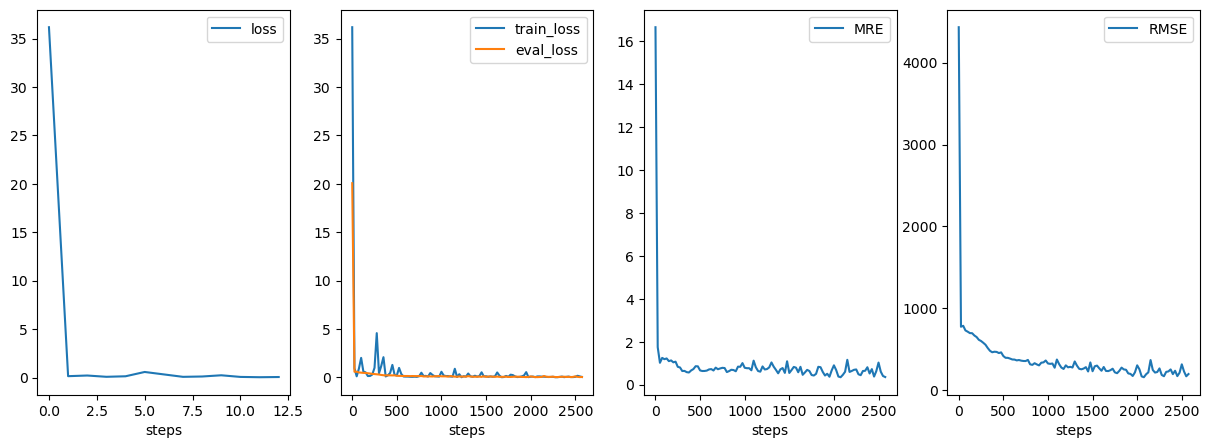

In [28]:
init_model_funcs = {
    ModelType.MLPTestGrouping.name: init_MLPTestGrouping_model,
    ModelType.GCNGrouping.name: init_GCNGrouping_model,
}

# model_type = ModelType.init_GCNGrouping_model
model_type = ModelType.GCNGrouping
init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)

single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)